In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [4]:
import keras
import os
from models import CNN

### Data initing and Data preprocessing

In [6]:
train_path = './../ml-data/Cat-Dog/train'
train_filenames = np.array(os.listdir(train_path))

In [7]:
import cv2

input_size = (70, 70)
def get_data(batch_size=25):
  targets = np.random.choice(train_filenames.shape[0], batch_size)
  y_batch = np.zeros(batch_size)
  # X_batch = np.zeros((batch_size, input_size[0], input_size[1], 3))
  X_batch = []
  for i, f in np.ndenumerate(train_filenames[targets]):
    category = f.split('.')[0]
    if category == 'dog':
      y_batch[i] = 0
    else :
      y_batch[i] = 1
    img = cv2.imread(train_path+"/"+f)
    resized_img = cv2.resize(img, dsize=input_size, interpolation=cv2.INTER_CUBIC)
    X_batch.append(resized_img)
  return np.array(X_batch), y_batch

In [38]:
X_test, y_test = get_data(batch_size=100)
y_test = y_test.astype(np.int)
y_test_ = np.zeros((y_test.size, 2))
y_test_[np.arange(y_test.size), y_test] = 1
X_test = X_test.transpose(0,3,1,2)

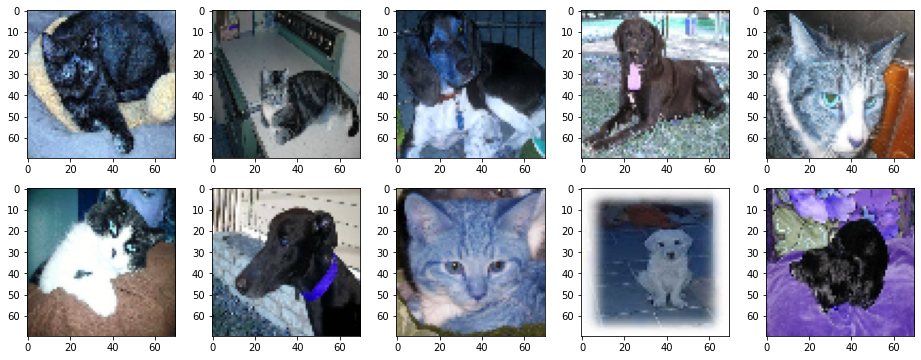

In [11]:
plt.figure(figsize=(16, 6))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_test[i])

In [40]:
from collections import OrderedDict

class CatDogClassifier:
  def __init__(self):
    self.params = {}
    self.params['W1'] = np.random.randn(32, 3, 3, 3) * 0.01
    self.params['b1'] = np.zeros(32)
    self.params['W2'] = np.random.randn(64, 32, 3, 3) * 0.01
    self.params['b2'] = np.zeros(64)
    self.params['W3'] = np.random.randn(128, 64, 3, 3) * 0.01
    self.params['b3'] = np.zeros(128)
    ####
    self.params['W4'] = np.random.randn(6272, 512) * np.sqrt(2 / 6272)
    self.params['b4'] = np.zeros(512)
    self.params['W5'] = np.random.randn(512, 2) * np.sqrt(1 / 512)
    self.params['b5'] = np.zeros(2)

    self.layers = OrderedDict()
    self.layers['Conv1'] = CNN.Convolution(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = CNN.Relu()
    self.layers['Pool1'] = CNN.Pooling(2, 2, stride=2)
    self.layers['Conv2'] = CNN.Convolution(self.params['W2'], self.params['b2'])
    self.layers['Relu2'] = CNN.Relu()
    self.layers['Pool2'] = CNN.Pooling(2, 2, stride=2)
    self.layers['Conv3'] = CNN.Convolution(self.params['W3'], self.params['b3'])
    self.layers['Relu3'] = CNN.Relu()
    self.layers['Pool3'] = CNN.Pooling(2, 2, stride=2)
    ####
    self.layers['Flattener'] = CNN.Flattener()
    self.layers['Affine1'] = CNN.Affine(self.params['W4'], self.params['b4'])
    self.layers['Relu4'] = CNN.Relu()
    self.layers['Affine2'] = CNN.Affine(self.params['W5'], self.params['b5'])
    self.last_layer = CNN.SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x
  
  def loss(self, x, t):
    y = self.predict(x)
    return self.last_layer.forward(y, t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t = np.argmax(t, axis=1)
    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def gradient(self, x, t):
    self.loss(x, t)

    dout = 1
    dout = self.last_layer.backward(dout)
    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)
    
    grads = {}
    grads['W1'] = self.layers['Conv1'].dw
    grads['b1'] = self.layers['Conv1'].db
    grads['W2'] = self.layers['Conv2'].dw
    grads['b2'] = self.layers['Conv2'].db
    grads['W3'] = self.layers['Conv3'].dw
    grads['b3'] = self.layers['Conv3'].db
    grads['W4'] = self.layers['Affine1'].dw
    grads['b4'] = self.layers['Affine1'].db
    grads['W5'] = self.layers['Affine2'].dw
    grads['b5'] = self.layers['Affine2'].db
    return grads


In [46]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
net = CatDogClassifier()

iter_num = 10000
lr = 0.01

batch_size = 25
epoch_size = max((iter_num // batch_size), 1)
keys = ['W1', 'W2', 'W3', 'W4', 'W5', 'b1', 'b2', 'b3', 'b4', 'b5']
for i in range(iter_num):
  print(i)
  X_batch, y_batch = get_data(batch_size=batch_size)
  y_batch = y_batch.astype(np.int)
  X_batch = X_batch.transpose(0,3,1,2)
  for i in range(3):
    X_batch[:,i,:,:] = scaler.fit_transform(X_batch[:,i,:,:].reshape(-1, 70*70)).reshape(batch_size, 1, 70, 70)
  X_batch = scaler.fit_transform(X_batch)
  y_batch_ = np.zeros((y_batch.size, 2))
  y_batch_[np.arange(y_batch.size), y_batch] = 1
  grads = net.gradient(X_batch, y_batch_)
  for key in keys:
    net.params[key] -= lr * grads[key]
  
#  if i % epoch_size == 0:
  if i % 20 == 0:
    test_acc = net.accuracy(X_test, y_test_)
    print(test_acc)

0


ValueError: ignored

In [20]:
a = np.array([1,2,3,4,5])
b = np.array([
              [1,2],
              [3,4],
              [5,6],
              [5,6],
              [5,6],
])

In [23]:
(a * b.T).T

array([[ 1,  2],
       [ 6,  8],
       [15, 18],
       [20, 24],
       [25, 30]])